# Multilabel Classification

In multi-label classification, each sample can have multiple labels associated with it, as opposed to the traditional single-label classification where each sample can have only one label associated with it. <br/>

This means that the output of a multi-label classifier is an array of probabilities, one for each label, indicating the probability of the input sample belonging to each label.

# Setting Up

In [1]:
!nvidia-smi

Sun Sep  3 16:33:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/text-classifier

/content/drive/MyDrive/text-classifier


# Data

In [7]:
df = pd.read_csv("book_details.csv")
df.head()

,title,description,genres
0,Awakening Your Money Chakras Secrets to Attracting Wealth and Success,"Welcome to our enlightening guide on ""Awakening Your Money Chakras: Secrets to Attracting Wealth and Success."" If you've ever wondered how some people effortlessly attract abundance into their lives while others struggle, this book has the answers you seek!\n\nIn this empowering read, we delve into the fascinating world of chakras, the energy centers within us that influence our financial well-being. From the Root Chakra to the Crown Chakra, we explore how each one impacts our money mindset and ability to manifest prosperity.\n\nLearn how to identify blockages and imbalances that may have ...","['Nonfiction', 'Business & Economics', 'Nonfiction', 'New Age', 'Meditation', 'Nonfiction', 'Business & Economics', 'Personal finance / money management', 'Nonfiction', 'Religion & Spirituality', 'Body, mind, & spirit', 'Inspiration & personal growth', 'Nonfiction', 'Self-improvement', 'Personal Growth / Success', 'Nonfiction', 'Business & Economics', 'Nonfiction', 'Business & Economics', 'Nonfiction', 'New Age', 'Meditation', 'Nonfiction', 'New Age', 'Meditation', 'Nonfiction', 'Business & Economics', 'Personal finance / money management', 'Nonfiction', 'Business & Economics', 'Personal f..."
1,Emotions A to Z,"""The Empathy Weave: Embracing Emotional Intelligence for Meaningful Connections"" is a captivating and transformative exploration of emotional intelligence and empathy—a tapestry of understanding and compassion that weaves hearts together with profound human connections. In this enlightening book, readers embark on a journey of self-discovery and growth, unlocking the power of emotional intelligence to enhance personal relationships, professional success, and overall well-being.\n\nDrawing upon the rich tapestry of emotional intelligence, this book delves deep into the intricacies of self-a...","['Nonfiction', 'Inspiration', 'General self-help', 'Nonfiction', 'Self-improvement', 'Anxieties & Phobias', 'Nonfiction', 'Inspiration', 'General self-help', 'Nonfiction', 'Inspiration', 'General self-help', 'Nonfiction', 'Self-improvement', 'Anxieties & Phobias', 'Nonfiction', 'Self-improvement', 'Anxieties & Phobias']"
2,The Art of Raise Capital for a New Venture,"""The Art of Raise Capital for Your New Venture"" is a practical and insightful guide that equips entrepreneurs with the knowledge and strategies needed to secure capital for their startup ventures. Authored with the understanding of the challenges faced by startup founders, this book serves as a valuable resource for aspiring entrepreneurs and seasoned founders alike.\n\nAt the core of successful fundraising lies the art of visionary storytelling. The book emphasizes the importance of articulating a powerful vision that resonates with potential investors. Through effective communication, en...","['Nonfiction', 'Business & Economics', 'Nonfiction', 'Business & Economics', 'Starting up', 'Nonfiction', 'Business & Economics', 'Budgeting', 'Nonfiction', 'Business & Economics', 'Nonfiction', 'Business & Economics', 'Nonfiction', 'Business & Economics', 'Starting up', 'Nonfiction', 'Business & Economics', 'Starting up', 'Nonfiction', 'Business & Economics', 'Budgeting', 'Nonfiction', 'Business & Economics', 'Budgeting']"
3,райдуга навколо сонця,"Життя заможного бізнесмена Марка можна побачити лише у казках: квартири, дорогі автомобілі, красива дівчина. Проте одна подія змінює Марка: врятувавши дівчинку з полум'я та сам ледь не загинувши, він полишає все та вирішує піти у паломництво до Єрусалиму у пошуках відповідей на свої запитання. Шлях далекий та складний, сповнений пригод та небезпек. Але Марк впевнений, що там, біля Гробу Господнього, на нього чекає відповідь на найбільшу таємницю.","['Fiction', 'Adventure', 'General', 'Fiction', 'Adventure', 'Travel', 'Fiction', 'Adventure', 'General', 'Fiction', 'Adventure', 'General', 'Fiction', 'Adventure', 'Travel', 'Fiction', 'Adventur

In [8]:
df. shape


(27478, 3)

In [10]:
df = df.dropna().reset_index(drop=True)
df.shape

(27478, 3)

In [11]:
genres_list = df.genres.to_list()
genre_count = {}
for genres in genres_list:
  genre_list = eval(genres)
  for genre in genre_list:
    if genre in genre_count.keys():
      genre_count[genre] += 1
    else:
      genre_count[genre] = 1
print(f"Total number of genres in the genres column: {len(genre_count)}")
print(genre_count)

Total number of genres in the genres column: 5807
{'Nonfiction': 167590, 'Business & Economics': 22209, 'New Age': 2647, 'Meditation': 498, 'Personal finance / money management': 423, 'Religion & Spirituality': 10584, 'Body, mind, & spirit': 2553, 'Inspiration & personal growth': 546, 'Self-improvement': 3900, 'Personal Growth / Success': 402, 'Inspiration': 1926, 'General self-help': 1401, 'Anxieties & Phobias': 159, 'Starting up': 915, 'Budgeting': 255, 'Fiction': 26263, 'Adventure': 2569, 'General': 8661, 'Travel': 9870, 'Science fiction': 1438, 'High tech': 134, 'Health, wellbeing, & medicine': 9969, 'Safety & first aid': 99, 'Physical impairments': 93, 'Education & Study Guides': 6189, 'Driver education': 48, 'Medicine': 1713, 'Critical care': 30, 'Surgery / neurosurgery': 24, 'Education': 630, 'Computers & technology': 165, 'Computers & Internet': 4947, 'Educational software': 57, 'Business administration': 330, 'Business ethics': 264, 'Essay': 834, 'Literature': 1918, 'Reference

In [12]:
threshold = int(len(df) * 0.01)
rare_genres = [key for key, value in genre_count.items() if value < threshold]
len(rare_genres), rare_genres[:5]

(5585,
 ['Anxieties & Phobias',
  'Budgeting',
  'High tech',
  'Safety & first aid',
  'Physical impairments'])

In [13]:
genres_list = df.genres.to_list()
revised_genre_list = []
indices_to_drop = []

for idx, genres in enumerate(genres_list):
  genre_list = eval(genres)
  revised_genres = []

  for genre in genre_list:
    if genre not in rare_genres:
      revised_genres.append(genre)

  if len(revised_genres) == 0:
    indices_to_drop.append(idx)
  else:
    revised_genre_list.append(revised_genres)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(26498, 3)

In [14]:
df['revised_genres'] = revised_genre_list

In [15]:
df.tail()

,title,description,genres,revised_genres
26493,The Blank Slate: The Modern Denial of Human Nature,"In The Blank Slate, Steven Pinker explores the idea of human nature and its moral, emotional, and political colorings. He shows how many intellectuals have denied the existence of human nature by embracing three linked dogmas: the Blank Slate (the mind has no innate traits), the Noble Savage (people are born good and corrupted by society), and the Ghost in the Machine (each of us has a soul that makes choices free from biology). Each dogma carries a moral burden, so their defenders have engaged in desperate tactics to discredit the scientists who are now challenging them.Pinker injects cal...","['Psychology', 'Science', 'Nonfiction', 'Philosophy', 'Sociology', 'Biology', 'Politics', 'Evolution', 'Anthropology', 'Neuroscience']","[Psychology, Science, Nonfiction, Philosophy, Sociology, Politics]"
26494,La leyenda del Rey Errante,"Cuenta la historia de Walid, un príncipe árabe que desea ser un gran poeta. Para ello, pide permiso a su padre para asistir al prestigioso certamen poético de Ukaz. Pero el rey le pone como condición que primero ha de demostrar que es el mejor poeta de su reino. Walid organiza su propio certamen de poesía pero, durante tres años consecutivos, le vence Hammad, un humilde tejedor de alfombras, pobre y analfabeto.Envidioso, Walid lo nombra historiador real y le impone una serie de tareas imposibles, como ordenar el enorme y caótico archivo de palacio o tejer una alfombra que contenga toda la ...","['Fantasy', 'Historical Fiction', 'Fiction', 'Young Adult', 'Adventure', 'Historical', 'Middle Grade', 'Spanish Literature', 'Childrens', 'Teen']","[Fantasy, Historical Fiction, Fiction, Young Adult, Adventure, Historical, Middle Grade, Childrens]"
26495,"This Way for the Gas, Ladies and Gentlemen","Tadeusz Borowski’s concentration camp stories were based on his own experiences surviving Auschwitz and Dachau. In spare, brutal prose he describes a world where where the will to survive overrides compassion and prisoners eat, work and sleep a few yards from where others are murdered; where the difference between human beings is reduced to a second bowl of soup, an extra blanket or the luxury of a pair of shoes with thick soles; and where the line between normality and abnormality vanishes. Published in Poland after the Second World War, these stories constitute a masterwork of world lite...","['History', 'Short Stories', 'Holocaust', 'Nonfiction', 'War', 'Polish Literature', 'Classics']","[History, Short Stories, Nonfiction, War, Classics]"
26496,The Warded Man,"As darkness falls after sunset, the corelings rise—demons who possess supernatural powers and burn with a consuming hatred of humanity. For hundreds of years the demons have terrorized the night, slowly culling the human herd that shelters behind magical wards—symbols of power whose origins are lost in myth and whose protection is terrifyingly fragile. It was not always this way. Once, men and women battled the corelings on equal terms, but those days are gone. Night by night the demons grow stronger, while human numbers dwindle under their relentless assault. Now, with hope for the future...","['Fantasy', 'Fiction', 'Epic Fantasy', 'High Fantasy', 'Magic', 'Demons', 'Adventure', 'Dark Fantasy', 'Science Fiction Fantasy', 'Audiobook']","[Fantasy, Fiction, Magic, Adventure, Science Fiction Fantasy, Audiobook]"
26497,Raising Steam,"Change is in the air for Moist von Lipwig, swindler, con-man, and (naturally) head of the Royal Bank and Post Office.A steaming, clanging new invention – a steam locomotive named Iron Girder, to be precise – is drawing astonished crowds. Suddenly it’s a matter of national importance that the trains run on time.Moist does not enjoy hard work. His input at the bank and post office consists mainly of words, which are not that heavy. Or greasy. And it certainly doesn’t involve rickety bridges, runaway cheeses or a fat controller with knuc

In [16]:
revised_genres_list = df.revised_genres.to_list()
revised_genre_count = {}
for genres in revised_genres_list:
  genre_list = genres
  for genre in genre_list:
    if genre in revised_genre_count.keys():
      revised_genre_count[genre] += 1
    else:
      revised_genre_count[genre] = 1
print(f"Number of genre: {len(revised_genre_count)}")
print(revised_genre_count)

Number of genre: 222
{'Nonfiction': 167590, 'Business & Economics': 22209, 'New Age': 2647, 'Meditation': 498, 'Personal finance / money management': 423, 'Religion & Spirituality': 10584, 'Body, mind, & spirit': 2553, 'Inspiration & personal growth': 546, 'Self-improvement': 3900, 'Personal Growth / Success': 402, 'Inspiration': 1926, 'General self-help': 1401, 'Starting up': 915, 'Fiction': 26263, 'Adventure': 2569, 'General': 8661, 'Travel': 9870, 'Science fiction': 1438, 'Health, wellbeing, & medicine': 9969, 'Education & Study Guides': 6189, 'Medicine': 1713, 'Education': 630, 'Computers & Internet': 4947, 'Business administration': 330, 'Essay': 834, 'Literature': 1918, 'Reference': 4360, 'Marketing': 516, 'Social Science': 5690, 'Psychology': 3273, 'Mental health': 471, 'Personal Growth / General': 327, 'History': 9956, 'American': 714, 'North America': 1944, 'Canada': 741, 'USA': 987, 'Art, Architecture, Photography': 12090, 'Fine art': 3261, 'Architecture': 4434, 'Engineering,

In [17]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(revised_genre_count.items())}
with open("genre_types_encoded.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [18]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
revised_genres_list = df.revised_genres.to_list()

for revised_genres in revised_genres_list:
  categorical_list = [0] * len(encode_genre_types)
  for genre in revised_genres:
    genre_type_index = encode_genre_types[genre]
    categorical_list[genre_type_index] = 1
  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

In [19]:
df['genre_cat_list'] = categorical_genre_list
df.head()

,title,description,genres,revised_genres,genre_cat_list
0,Awakening Your Money Chakras Secrets to Attracting Wealth and Success,"Welcome to our enlightening guide on ""Awakening Your Money Chakras: Secrets to Attracting Wealth and Success."" If you've ever wondered how some people effortlessly attract abundance into their lives while others struggle, this book has the answers you seek!\n\nIn this empowering read, we delve into the fascinating world of chakras, the energy centers within us that influence our financial well-being. From the Root Chakra to the Crown Chakra, we explore how each one impacts our money mindset and ability to manifest prosperity.\n\nLearn how to identify blockages and imbalances that may have ...","['Nonfiction', 'Business & Economics', 'Nonfiction', 'New Age', 'Meditation', 'Nonfiction', 'Business & Economics', 'Personal finance / money management', 'Nonfiction', 'Religion & Spirituality', 'Body, mind, & spirit', 'Inspiration & personal growth', 'Nonfiction', 'Self-improvement', 'Personal Growth / Success', 'Nonfiction', 'Business & Economics', 'Nonfiction', 'Business & Economics', 'Nonfiction', 'New Age', 'Meditation', 'Nonfiction', 'New Age', 'Meditation', 'Nonfiction', 'Business & Economics', 'Personal finance / money management', 'Nonfiction', 'Business & Economics', 'Personal f...","[Nonfiction, Business & Economics, Nonfiction, New Age, Meditation, Nonfiction, Business & Economics, Personal finance / money management, Nonfiction, Religion & Spirituality, Body, mind, & spirit, Inspiration & personal growth, Nonfiction, Self-improvement, Personal Growth / Success, Nonfiction, Business & Economics, Nonfiction, Business & Economics, Nonfiction, New Age, Meditation, Nonfiction, New Age, Meditation, Nonfiction, Business & Economics, Personal finance / money management, Nonfiction, Business & Economics, Personal finance / money management, Nonfiction, Religion & Spiritualit...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,Emotions A to Z,"""The Empathy Weave: Embracing Emotional Intelligence for Meaningful Connections"" is a captivating and transformative exploration of emotional intelligence and empathy—a tapestry of understanding and compassion that weaves hearts together with profound human connections. In this enlightening book, readers embark on a journey of self-discovery and growth, unlocking the power of emotional intelligence to enhance personal relationships, professional success, and overall well-being.\n\nDrawing upon the rich tapestry of emotional intelligence, this book delves deep into the intricacies of self-a...","['Nonfiction', 'Inspiration', 'General self-help', 'Nonfiction', 'Self-improvement', 'Anxieties & Phobias', 'Nonfiction', 'Inspiration', 'General self-help', 'Nonfiction', 'Inspiration', 'General self-help', 'Nonfiction', 'Self-improvement', 'Anxieties & Phobias', 'Nonfiction', 'Self-improvement', 'Anxieties & Phobias']","[Nonfiction, Inspiration, General self-help, Nonfiction, Self-improvement, Nonfiction, Inspiration, General self-help, Nonfiction, Inspiration, General self-help, Nonfiction, Self-improvement, Nonfiction, Self-improvement]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,The Art of Raise Capital for a New Venture,"""The Art of Raise Capital for Your New Venture"" is a practical and insightful guide that equips entrepreneurs with the knowledge and strategies needed to secure capital for their startup ventures. Authored with the understanding 

# Dataloaders and Modeling

In [20]:
labels = list(encode_genre_types.keys())

In [21]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [22]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('genre_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [23]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "dataloaders/dls-book-genre-ml-classifier.pkl")

In [ ]:
# dls = torch.load("dataloaders/dls-multilabel-book-classifier.pkl")

In [24]:
dls.vocab

['Nonfiction', 'Business & Economics', 'New Age', 'Meditation', 'Personal finance / money management', 'Religion & Spirituality', 'Body, mind, & spirit', 'Inspiration & personal growth', 'Self-improvement', 'Personal Growth / Success', 'Inspiration', 'General self-help', 'Starting up', 'Fiction', 'Adventure', 'General', 'Travel', 'Science fiction', 'Health, wellbeing, & medicine', 'Education & Study Guides', 'Medicine', 'Education', 'Computers & Internet', 'Business administration', 'Essay', 'Literature', 'Reference', 'Marketing', 'Social Science', 'Psychology', 'Mental health', 'Personal Growth / General', 'History', 'American', 'North America', 'Canada', 'USA', 'Art, Architecture, Photography', 'Fine art', 'Architecture', 'Engineering, trades, & technology', 'Screenplays', 'Romance', 'Drama', 'Fantasy', 'Performing arts', 'Biography', 'War', 'LGBTQ+', 'Christian', 'Suspense', 'Horror', 'Occult', 'Anthologies', 'Short stories - single author', 'Literary', 'Contemporary', 'Holiday', 'R

In [25]:
dls.show_batch(dataloaders=dls, max_n=3, trunc_at=512)

,text,target
0,২০০৫ সালে ময়মনসিঙহ মেডিক্যাল কলেজের ছাত্র মেহদি হাসান খান ও তার বন্ধুদের প্রতিষ্ঠান অমিক্রণ ল্যাব অভ্র বাংলা টাইপিং সফটওয়্যারের মাধ্যমে বাংলা ভাষা অনলাইনে উন্মুক্ত করেন। অভ্রর ইউনিকোড শক্তিতে খুলে যায় বাংলা ভাষায় সৃষ্টিশীলতার অবারিত সম্ভবনার দুয়ার�,"[Nonfiction, Religion & Spirituality, Body, mind, & spirit, Social Science, Political, Philosophy]"
1,"ஆலயங்களும் அறிவியல் தகவல்களும் என்ற என்னுடைய இந்த நூல், முதலாவதாக இருபத்தேழு நட்சத்திரங்களுக்கான ஸ்தல விருட்சங்களின் விஞ்ஞான தகவல்களும், பிறந்த நட்சத்திரங்களுக்கான வழிபாட்டு ஸ்தலங்கள�","[Nonfiction, Religion & Spirituality, Science & Nature]"
2,માનવતા ચેતનાના પ્રથમ વિકાસથી સમજી ગઈ છે કે કેટલીક મહત્વપૂર્ણ ઘટનાઓ તકને કારણે નથી. ન સમજાય તેવી ઘટનાઓ ઉચ્ચ દાર્શનિક અથવા દૈવી સ્તરના સંકેતો છે. આ બુદ્ધિ માનવ અંતઃકરણ સાથે વાતચીત કરવા માંગે છે.\n\nક,"[Nonfiction, Philosophy, Science & Nature]"


In [26]:
doc(accuracy_multi)

In [27]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.5)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

# Stage - 0

In [28]:
learner.freeze()

SuggestedLRs(slide=0.0010000000474974513, valley=0.0002290867705596611)

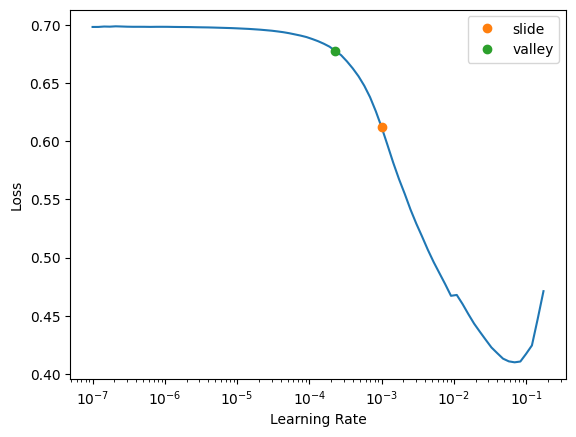

In [29]:
learner.lr_find(suggest_funcs=[slide, valley])

In [30]:
learner.fit_one_cycle(6,0.00023)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.085467,0.083930,0.980178,03:36
1,0.063082,0.060715,0.982887,03:36
2,0.052934,0.051727,0.984189,03:34
3,0.049546,0.048084,0.984968,03:36
4,0.048104,0.046881,0.985264,03:34
5,0.047700,0.046656,0.985310,03:41


In [31]:
learner.save("book-genre-classifier-stage-0")

Path('models/book-genre-classifier-stage-0.pth')

In [32]:
learner.export("models/book-genre-classifier-stage-0.pkl")

# Stage - 1

In [ ]:
 learner.load("book-classifier-stage-0")

In [33]:
learner.unfreeze()

SuggestedLRs(slide=0.0063095735386013985, valley=3.311311274956097e-06)

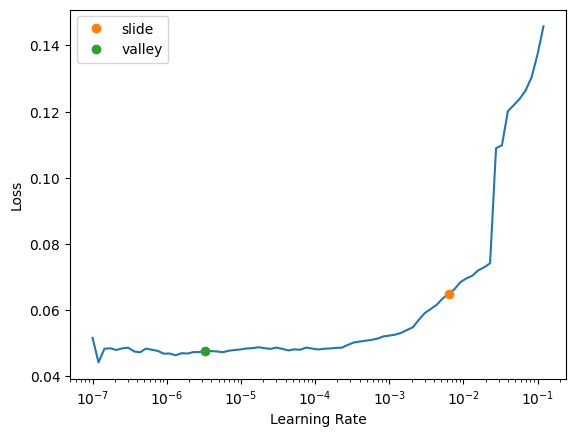

In [35]:
learner.lr_find(suggest_funcs=[slide, valley])

In [38]:
learner.fit_one_cycle(7,slice(0.0063, 3.3e-06))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.047497,0.047108,0.984924,04:26
1,0.045661,0.045650,0.985484,04:26
2,0.037313,0.044110,0.986041,04:28
3,0.031678,0.040765,0.987162,04:26
4,0.027783,0.039221,0.987765,04:28
5,0.024735,0.038558,0.988138,04:26
6,0.023045,0.038607,0.988209,04:27


In [39]:
learner.save("book-genre-classifier-stage-1")

Path('models/book-genre-classifier-stage-1.pth')

In [40]:
learner.export("models/book-genre-classifier-stage-1.pkl")